#  Starting From a Previous Reconstruction
**Learning how to start refinement from an existing reconstruction and use this strategy to reconstruct a large electron ptychography datasets.**

In this example, we are going to reconstruct the full graphene data set from ePSIC a subsection of which was already used in [Working With Electron Data](./00_electron_data.ipynb). The goal is to do a few iterations of ePIE to find a reasonable probe/object
followed by refinement using the maximum-likelihood (ML) engine. Unfortunately, there are a few incompatibilities between these two engines in PtyPy namely that ePIE requires data to be loaded in a single block whereas ML is fine with smaller block sizes. So, instead of simply [chaining the engines](./01_chaining_multiple_engines.ipynb) we can first run ePIE, save the results to a .ptyr file and then load the initial ePIE reconstruction into a separate ML script. This way, we can use different data loading parameters for the two parts of the reconstructions and also make use of the multi-GPU capabilities of the ML engine (ePIE by design needs to run in a single GPU instance).


## The data

| **Data file** |  **Type** | **Download** | **Courtesy of** | **Reference** |
| :- | :- | :- | :-: | :-: |
| 20200130_163208.h5 | Raw | dls_epsic_80kV_graphene.zip | Chris Allen | [doi](https://10.5281/zenodo.11501765) |

At the ePSIC instrument at the Diamond Light Source, raw data is written into HDF5 files. In this example, we are looking at the graphene data stored in ```"dls_epsic_80kV_graphene/20200130_163208.h5"``` and inspect the relevant entry

```python
import h5py, os
tutorial_data_home = "../../data/"
dataset = "dls_epsic_80kV_graphene/20200130_163208.h5"
path_to_data = os.path.join(tutorial_data_home, dataset)
with h5py.File(path_to_data) as f:
    keys = ["data/frames"]
    print("The file {} has the following relevant entries: \n".format(path_to_data))
    print('\n'.join('\t* {0:<30} shape = {1:}'.format(k,f[k].shape) for k in keys))
```

for the diffraction intensities

```
The file ../../data/dls_epsic_80kV_graphene/20200130_163208.h5 has the following relevant entries: 

	* data/frames                    shape = (65025, 128, 128)
```

In addition, we have been provided with some meta information (which is also stored in an HDF5 files for more recent data collections at ePSIC), namely
- scan rotation: 60 degrees
- scan step size: 3.71875e-11 m
- nr. of scan positions: 255 x 255
- electron energy: 80 kV
- detector pixelsize: 220 um (4x binning, original frames are 512x512 with 55 um pixelsize)
- detector distance: 0.1732 m

---

In [ ]:
import h5py, os
tutorial_data_home = "../../data/"
dataset = "dls_epsic_80kV_graphene/20200130_163208.h5"
path_to_data = os.path.join(tutorial_data_home, dataset)
with h5py.File(path_to_data) as f:
    keys = ["data/frames"]
    print("The file {} has the following relevant entries: \n".format(path_to_data))
    print('\n'.join('\t* {0:<30} shape = {1:}'.format(k,f[k].shape) for k in keys))

## Loading the data

Since we have only been provided with diffraction intensities and meta information, but no explicit scan positions, we need to use a custom ```EpsicHdf5Loader``` that has been created specifically for the ePSIC instrument by sub-classing the ```Hdf5Loader``` to make the relevant calculation of e.g. the scan positions based on the given meta information. We first need to import this new PtyScan module

```python
ptypy.load_ptyscan_module("epsic_loader")
```

specify the loader class

```python
p.scans.scan_00.data = u.Param()
p.scans.scan_00.data.name = 'EpsicHdf5Loader'
p.scans.scan_00.data.orientation = 2
```

provide the correct path to the intensities

```python
p.scans.scan_00.data.intensities = u.Param()
p.scans.scan_00.data.intensities.file = path_to_data
p.scans.scan_00.data.intensities.key = "data/frames"
```

provide information about the scan parameters

```python
p.scans.scan_00.data.rotation = 60
p.scans.scan_00.data.stepsize = 3.71875e-11
p.scans.scan_00.data.numpos = 255
```

and other relevant meta information on the energy and detector distance/psize

```python
p.scans.scan_00.data.electron_data = True
p.scans.scan_00.data.psize = 220e-6
p.scans.scan_00.data.energy = 80
p.scans.scan_00.data.distance = 0.1732
```



## The scan model

As the scan model, we should in principle use the ```GradFull``` model which is preferable for ePIE reconstruction since it does not create the exit wave buffers. However, even though we want to read all the data in a single block of frames, we should still use the ```BlockGradFull``` model but with ```frames_per_block``` larger than the total nr. of frames. That is because in their current implementation, the block scan models are more efficient when loading data into PtyPy compare to the regular ```Full``` models. 

```python
p.frames_per_block = 100000

p.scans = u.Param()
p.scans.scan_00 = u.Param()
p.scans.scan_00.name = 'BlockGradFull'
```

This particular data set benefits from using $3$ incoherent probe modes, which can be specified with ```coherence.probe_modes```

```python
p.scans.scan_00.coherence = u.Param()
p.scans.scan_00.coherence.num_probe_modes = 3
p.scans.scan_00.coherence.num_object_modes = 1
```

## Initial ePIE reconstruction

For ePIE, we use the same set of parameters as before with ```alpha=0.9```, ```beta=0.1``` and ```object_norm_is_global=True``` 

```python
p.engines = u.Param()
p.engines.engine = u.Param()
p.engines.engine.name = "EPIE_cupy"
p.engines.engine.numiter = 5
p.engines.engine.numiter_contiguous = 1
p.engines.engine.alpha = 0.9
p.engines.engine.beta = 0.1
p.engines.engine.object_norm_is_global = True
p.engines.engine.probe_support = None
p.engines.engine.probe_fourier_support = None
p.engines.engine.probe_update_start = 0
p.engines.engine.record_local_error = False
```

resulting in the following initial reconstruction after $5$ iterations of ePIE

![](./_assets/epsic_recons_epie.png)

---

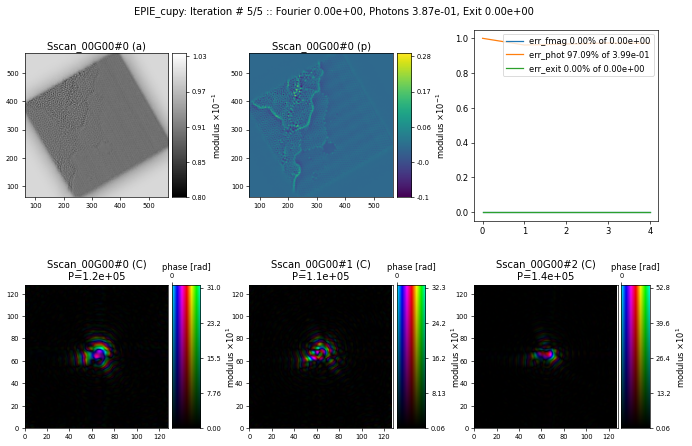


==== This reconstruction relied on the following work ==========================
The Ptypy framework:
    Enders B. and Thibault P., "A computational framework for ptychographic reconstructions" Proc. Royal Soc. A 472 (2016) 20160640, doi: 10.1098/rspa.2016.0640.
The ePIE reconstruction algorithm:
    Maiden A. and Rodenburg J., "An improved ptychographical phase retrieval algorithm for diffractive imaging" Ultramicroscopy 10 (2009) 1256, doi: 10.1016/j.ultramic.2009.05.012.


<Figure size 640x480 with 0 Axes>

In [1]:
import ptypy, os
import ptypy.utils as u

# This will import the EpsicHdf5Loader class
ptypy.load_ptyscan_module("epsic_loader")

# This will import the GPU engines
ptypy.load_gpu_engines("cupy")  

# Root directory of tutorial data
tutorial_data_home = "../../data/"

# Dataset for this tutorial
dataset = "dls_epsic_80kV_graphene/20200130_163208.h5"

# Absolute path to HDF5 file with raw data
path_to_data = os.path.join(tutorial_data_home, dataset)

# Create parameter tree
p = u.Param()

# Set verbose level to info
p.verbose_level = "interactive"

# Scan label
p.run = "dls_epsic_graphene"

# Make sure bigger than nr. of frames 
# because of ePIE
p.frames_per_block = 100000

# Set io settings (no files saved)
p.io = u.Param()
p.io.home = "./"
p.io.rfile = "recons/%(run)s_%(engine)s_%(iterations)04d.ptyr"
p.io.autosave = u.Param(active=False)
p.io.interaction = u.Param(active=False)

# Live-plotting during the reconstruction
p.io.autoplot = u.Param()
p.io.autoplot.active=True
p.io.autoplot.threaded = False
p.io.autoplot.layout = "jupyter"
p.io.autoplot.interval = 1

# Define the scan model
p.scans = u.Param()
p.scans.scan_00 = u.Param()
p.scans.scan_00.name = 'BlockGradFull'

# Initial illumination (based on simulated optics)
p.scans.scan_00.illumination = u.Param()
p.scans.scan_00.illumination.model = None
p.scans.scan_00.illumination.photons = None
p.scans.scan_00.illumination.aperture = u.Param()
p.scans.scan_00.illumination.aperture.form = "circ"
p.scans.scan_00.illumination.aperture.size = 0.011
p.scans.scan_00.illumination.propagation = u.Param()
p.scans.scan_00.illumination.propagation.focussed = 0.1732
p.scans.scan_00.illumination.propagation.parallel = -1.5e-8
p.scans.scan_00.illumination.diversity = u.Param()
p.scans.scan_00.illumination.diversity.power = 0.1
p.scans.scan_00.illumination.diversity.noise = [0.5,0.2]

# Initial object
p.scans.scan_00.sample = u.Param()
p.scans.scan_00.sample.model = None
p.scans.scan_00.sample.diversity = None
p.scans.scan_00.sample.process = None

# Coherence parameters (modes)
p.scans.scan_00.coherence = u.Param()
p.scans.scan_00.coherence.num_probe_modes = 3
p.scans.scan_00.coherence.num_object_modes = 1

# Data loader
p.scans.scan_00.data = u.Param()
p.scans.scan_00.data.name = 'EpsicHdf5Loader'
p.scans.scan_00.data.orientation = 2

# Read diffraction data
p.scans.scan_00.data.intensities = u.Param()
p.scans.scan_00.data.intensities.file = path_to_data
p.scans.scan_00.data.intensities.key = "data/frames"

# Scan positions
p.scans.scan_00.data.rotation = 60
p.scans.scan_00.data.stepsize = 3.71875e-11
p.scans.scan_00.data.numpos = 255
# p.scans.scan_00.data.positions = u.Param()
# p.scans.scan_00.data.positions.bounding_box = u.Param()
# p.scans.scan_00.data.positions.bounding_box.fast_axis_bounds = [50,200]
# p.scans.scan_00.data.positions.bounding_box.slow_axis_bounds = [50,200]

# Meta information
# electron_data needs to be set to True 
# if energy is given as electron energy in kV
p.scans.scan_00.data.electron_data = True
p.scans.scan_00.data.psize = 220e-6
p.scans.scan_00.data.energy = 80
p.scans.scan_00.data.distance = 0.1732

# Read detector mask
# p.scans.scan_00.data.mask = u.Param()
# p.scans.scan_00.data.mask.file = path_to_data
# p.scans.scan_00.data.mask.key = "data/mask"
# p.scans.scan_00.data.mask.invert = True

# Determine diffraction center from the data
p.scans.scan_00.data.auto_center = True

# Reconstruct using GPU-accelerated ePIE
p.engines = u.Param()
p.engines.engine = u.Param()
p.engines.engine.name = "EPIE_cupy"
p.engines.engine.numiter = 5
p.engines.engine.numiter_contiguous = 1
p.engines.engine.alpha = 0.9
p.engines.engine.beta = 0.1
p.engines.engine.object_norm_is_global = True
p.engines.engine.probe_support = None
p.engines.engine.probe_fourier_support = None
p.engines.engine.probe_update_start = 0
p.engines.engine.record_local_error = False

# Run reconstruction
P = ptypy.core.Ptycho(p,level=5)

## Refinement using maximum likelihood (ML) engine

For the second part of the reconstruction, we use the same block scan model (```BlockGradFull```) since ML also does not require any exit wave buffers, but with a smaller block size

```python
p.frames_per_block = 4000
```

to actually load the data in blocks. We also need to load the previous results of the ePIE reconstruction as a starting guess for probe 

```python
p.scans.scan_00.illumination = u.Param()
p.scans.scan_00.illumination.photons = None
p.scans.scan_00.illumination.model = "recon"
p.scans.scan_00.illumination.recon = u.Param()
p.scans.scan_00.illumination.recon.rfile = "./recons/dls_epsic_graphene_EPIE_cupy_0005.ptyr"
p.scans.scan_00.illumination.aperture = u.Param()
p.scans.scan_00.illumination.aperture.form = None
p.scans.scan_00.illumination.diversity = None
```

and object

```python
p.scans.scan_00.sample = u.Param()
p.scans.scan_00.sample.model = "recon"
p.scans.scan_00.sample.recon = u.Param()
p.scans.scan_00.sample.recon.rfile = "./recons/dls_epsic_graphene_EPIE_cupy_0005.ptyr"
p.scans.scan_00.sample.diversity = None
p.scans.scan_00.sample.process = None
```

and provide standard ML engine parameters

```python
p.engines = u.Param()
p.engines.engine = u.Param()
p.engines.engine.name = "ML_cupy"
p.engines.engine.numiter = 195
p.engines.engine.numiter_contiguous = 1
p.engines.engine.ML_type = "Gaussian"
p.engines.engine.reg_del2 = True
p.engines.engine.reg_del2_amplitude = 0.001
p.engines.engine.scale_precond = True
p.engines.engine.floating_intensities = False
p.engines.engine.probe_update_start = 0
```

Finally, we save the parameters into a config file: [./config/dls_epsic_graphene_refine.yaml](./config/dls_epsic_graphene_refine.yaml), write a Python run script

```python
with open("./ptypy_run_dls_epsic_graphene_refine.py", "w") as f:
    f.write("""\
import ptypy
ptypy.load_ptyscan_module("epsic_loader")
ptypy.load_gpu_engines("cupy")  
p = ptypy.utils.param_from_yaml("config/dls_epsic_graphene_refine.yaml")
P = ptypy.core.Ptycho(p,level=5)
""")
```

and execute the ML refinement in a new terminal using 4 GPUs

```bash
cd $HOME/tutorials/notebooks/ptychography_with_electrons
srun -n 4 -c 2 --gpus-per-task=1 --gpu-bin=None python ptypy_run_dls_epsic_graphene_refine.py
```

`````{admonition} Challenge 
:class: attention
Run the ePSIC graphene ML refinement script in a terminal using 4 GPUs and compare the output against the initial ePIE reconstruction.
`````

---

In [ ]:
with open("./ptypy_run_dls_epsic_graphene_refine.py", "w") as f:
    f.write("""\
import ptypy
ptypy.load_ptyscan_module("epsic_loader")
ptypy.load_gpu_engines("cuda")  
p = ptypy.utils.param_from_yaml("config/dls_epsic_graphene_refine.yaml")
P = ptypy.core.Ptycho(p,level=5)
""")

In [ ]:
import ptypy.utils.plot_client as pc
fig1 = pc.figure_from_ptycho(P)
fig1.savefig("./recons_after_epie.png", dpi=300)

In [ ]:
fig2 = pc.figure_from_ptyr("./recons/dls_epsic_graphene_ML_pycuda_0100.ptyr")
fig2.savefig("./recons_after_epie_ml.png", dpi=300)

`````{admonition} Tip 
:class: tip
Save the figures in a PNG file with high resolution (dpi=300) and open via file browser to inspect features in different reconstructions.
`````